In [1]:
import pandas as pd
import numpy as np
import os
import math
from scipy.special import softmax

In [2]:
correct_gene_df = pd.read_csv('TNAMSE_pedia_results/correct_pedia_results_2812.csv')

In [3]:
results_list = []
for i in ['lirical', 'exomizer', 'xrare', 'amelie']:
    results = pd.read_csv('TNAMSE_pedia_results/pedia_TNAMSE_{}_filter/rank.csv'.format(i), header=None)
    results_gestalt = pd.read_csv('TNAMSE_pedia_results/pedia_TNAMSE_{}_gestalt_filter/rank.csv'.format(i), header=None)
    results_list.append([results, results_gestalt])


In [4]:
main_ids = ['DE87NGSUKBR10899' if i == 'DE87NGSUKBR108993' else i for i in results_list[0][0][0].values]

In [5]:
def get_sample_ranks(rank_df):
    sample_all_ranks = np.array([])
    for _, row in rank_df.iterrows():
        rank = row[1]
        if rank > 100:
            rank = 101
        sample_rank = [0] * (rank - 1) + [1] * (100 - rank + 1)
        if len(sample_all_ranks) == 0:
            sample_all_ranks = np.array([sample_rank])
        else:
            sample_all_ranks = np.append(sample_all_ranks, [np.array(sample_rank)], axis=0)
    return sample_all_ranks


In [6]:
rank_list = []
for i in results_list:
    ranks = get_sample_ranks(i[0])
    ranks_gestalt = get_sample_ranks(i[1])
    rank_list.append([ranks, ranks_gestalt])


In [7]:
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

In [8]:
def calc_conf_interval(all_ranks):
    means = []
    intervals = []
    for i in range(100):
        result = bs.bootstrap(all_ranks[:,i], stat_func=bs_stats.mean)
        means.append(result.value*100)
        intervals.append([result.lower_bound*100, result.upper_bound*100])
    return means, intervals

In [9]:
total_means = []
total_intervals = []
for ranks in rank_list:
    mean_results, interval_results = calc_conf_interval(ranks[0])
    mean_results_g, interval_results_g = calc_conf_interval(ranks[1])
    total_means.append([mean_results, mean_results_g])
    total_intervals.append(np.clip([interval_results, interval_results_g], 0 ,100))

In [10]:
total_intervals = np.array(total_intervals)


----LIRICAL----
LIRICAL   : Top-1:48.94; Top-10:85.11
LIRICAL+GM: Top-1:57.45; Top-10:91.49
change: Top-1:8.51; Top-10:6.38
----Exomiser----
Exomiser   : Top-1:57.45; Top-10:86.17
Exomiser+GM: Top-1:60.64; Top-10:95.74
change: Top-1:3.19; Top-10:9.57
----Xrare----
Xrare   : Top-1:41.49; Top-10:84.04
Xrare+GM: Top-1:51.06; Top-10:92.55
change: Top-1:9.57; Top-10:8.51
----Amelie----
Amelie   : Top-1:14.89; Top-10:72.34
Amelie+GM: Top-1:53.19; Top-10:89.36
change: Top-1:38.30; Top-10:17.02


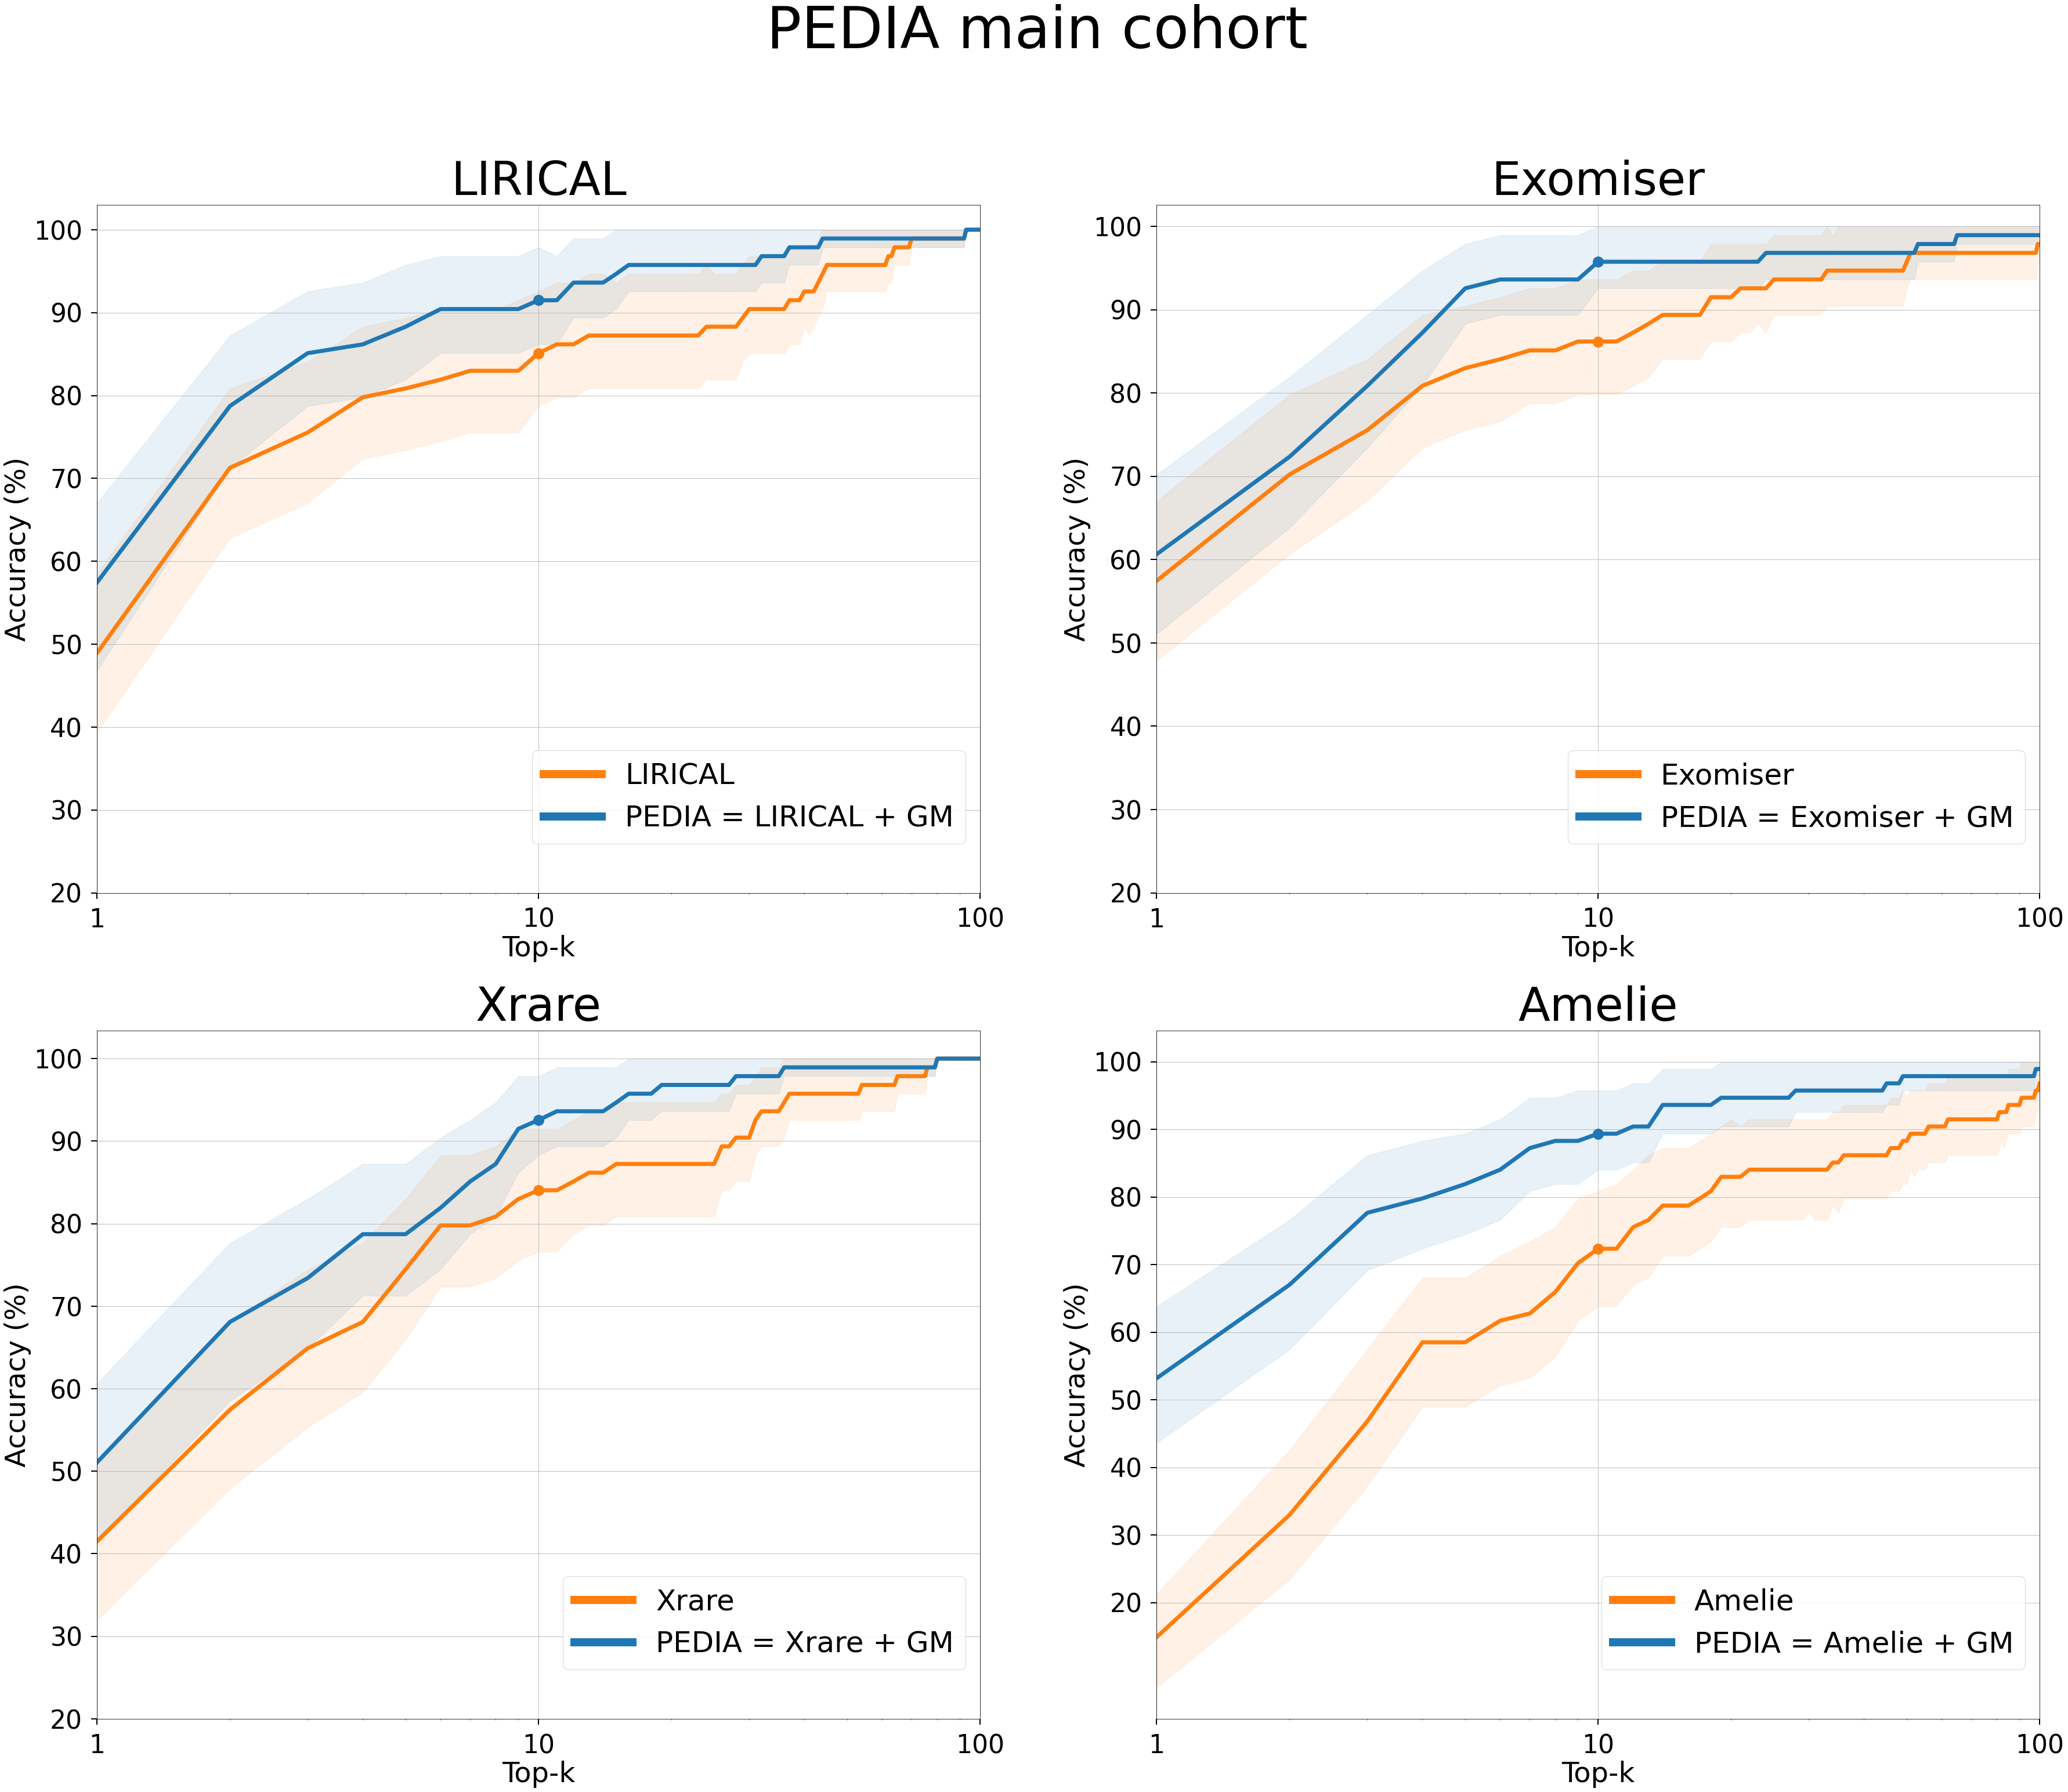

In [11]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(60, 48))

markersize = 18
linewidth = 7
tick_size = 44
label_size = 48

for idx, method in enumerate(['LIRICAL', 'Exomizer', 'Xrare', 'Amelie']):
    if method == 'Exomizer':
        method = 'Exomiser'
    x = np.array([i for i in range(1, 101)])

    axs[idx//2, idx%2].plot(x, total_means[idx][0], markersize=markersize, linewidth=linewidth, label=method, color='tab:orange')
    axs[idx//2, idx%2].plot([10], total_means[idx][0][9], marker='o', markersize=markersize, color='tab:orange', linestyle = 'None')
    axs[idx//2, idx%2].fill_between(x, (total_intervals[idx][0][:,0]), (total_intervals[idx][0][:,1]), color='tab:orange', alpha=.1)

    axs[idx//2, idx%2].plot(x, total_means[idx][1], linewidth=linewidth, label='PEDIA = '+method + ' + ' + 'GM', color='tab:blue')
    axs[idx//2, idx%2].plot([10], total_means[idx][1][9], marker='o', markersize=markersize, color='tab:blue', linestyle = 'None')

    axs[idx//2, idx%2].fill_between(x, (total_intervals[idx][1][:,0]), (total_intervals[idx][1][:,1]), color='tab:blue', alpha=.1)
    axs[idx//2, idx%2].tick_params(pad=15, length=10, width=2, labelsize=tick_size)

    axs[idx//2, idx%2].set_xlabel('Top-k', fontsize=label_size)
    axs[idx//2, idx%2].set_ylabel('Accuracy (%)', fontsize=label_size)

    axs[idx//2, idx%2].set_yticks([i for i in range(20, 101, 10)], [i for i in range(20, 101, 10)])

    leg = axs[idx//2, idx%2].legend(loc='lower right', bbox_to_anchor=(1, 0.05), prop={'size': 50})
    axs[idx//2, idx%2].set_xscale("log")  
    for line in leg.get_lines():
        line.set_linewidth(14.0)
        line.set_markersize(40)

    from matplotlib.ticker import ScalarFormatter
    for axis in [axs[idx//2, idx%2].xaxis, axs[idx//2, idx%2].yaxis]:
        axis.set_major_formatter(ScalarFormatter())
    axs[idx//2, idx%2].margins(x=0)
    axs[idx//2, idx%2].set_xticks([1, 10, 100], [1, 10, 100])
    axs[idx//2, idx%2].set_title(method, fontsize=80)
    axs[idx//2, idx%2].grid()
    print('----{}----'.format(method))
    print('{}   : Top-1:{:.2f}; Top-10:{:.2f}'.format(method, total_means[idx][0][0], total_means[idx][0][9]))
    print('{}+GM: Top-1:{:.2f}; Top-10:{:.2f}'.format(method, total_means[idx][1][0], total_means[idx][1][9]))
    print('change: Top-1:{:.2f}; Top-10:{:.2f}'.format(total_means[idx][1][0]-total_means[idx][0][0], total_means[idx][1][9]-total_means[idx][0][9]))
fig.suptitle('PEDIA main cohort', fontsize=100)
fig.savefig('pedia_tnamse_main_results_other_methods_revision.svg')
fig.savefig('pedia_tnamse_main_results_other_methods_revision.png')
plt.show()

In [12]:
#rank = pd.read_csv('classifier/pedia_v2_case_2812/rank.csv', header=None)
tnamse_results_list = []
for i in ['pedia', 'cadd_cada_', 'cadd_', 'gestalt_']:
    if i == 'pedia':
        i = ''

    results = pd.read_csv('TNAMSE_pedia_results/pedia_TNAMSE_revision_{}main_filter/rank.csv'.format(i), header=None)
    results = results[results[0].isin(main_ids)]
    tnamse_results_list.append(results)

In [13]:
tnamse_rank_list = []
for i in tnamse_results_list:
    ranks = get_sample_ranks(i)
    tnamse_rank_list.append(ranks)

tnamse_total_means = []
tnamse_total_intervals = []
for ranks in tnamse_rank_list:
    mean_results, interval_results = calc_conf_interval(ranks)
    tnamse_total_means.append(mean_results)
    tnamse_total_intervals.append(np.clip(interval_results, 0 ,100))

----PEDIA = CADD + CADA + GM----
PEDIA = CADD + CADA + GM: Top-1:51.06; Top-10:82.98
----CADD + CADA----
CADD + CADA: Top-1:24.47; Top-10:68.09


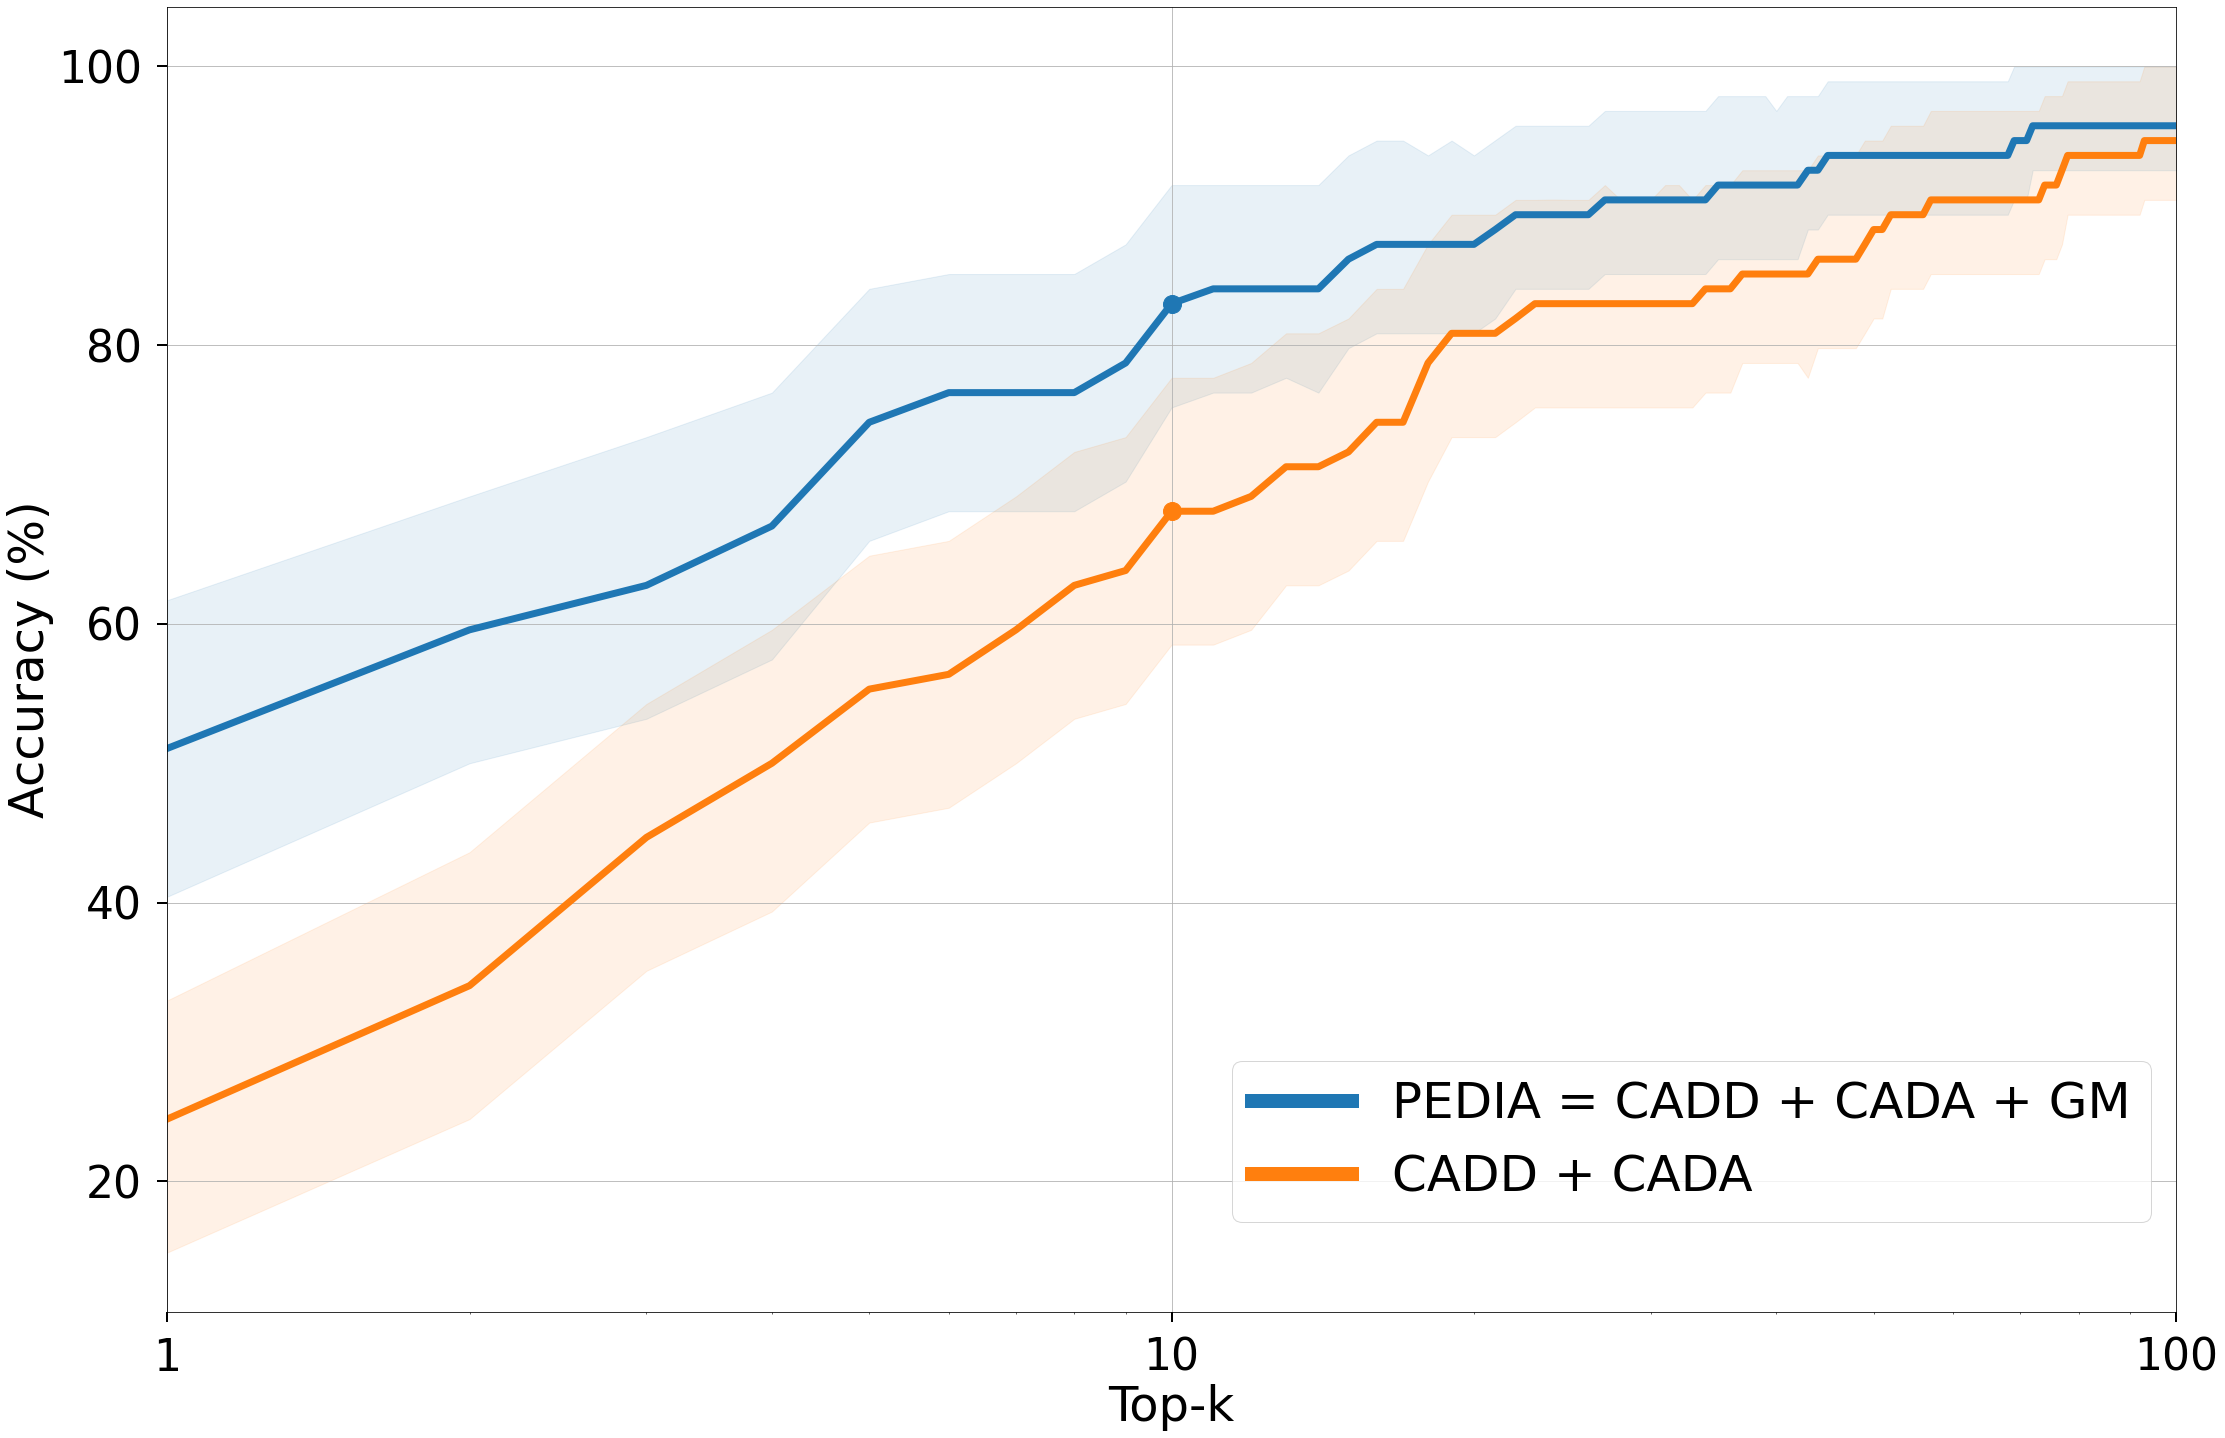

In [14]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(36, 24))

x = np.array([i for i in range(1, 101)])

markersize = 18
linewidth = 7
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:grey']
for idx, method in enumerate(['PEIDA', 'CADD + CADA']):
    if method == 'PEIDA':
        method = 'PEDIA = CADD + CADA + GM'
    ax.plot(x, tnamse_total_means[idx], markersize=markersize, linewidth=linewidth, label=method, color=colors[idx])
    ax.plot([10], tnamse_total_means[idx][9], marker='o', markersize=markersize, color=colors[idx], linestyle = 'None')
    ax.fill_between(x, (tnamse_total_intervals[idx][:,0]), (tnamse_total_intervals[idx][:,1]), color=colors[idx], alpha=.1)
    print('----{}----'.format(method))
    print('{}: Top-1:{:.2f}; Top-10:{:.2f}'.format(method, tnamse_total_means[idx][0], tnamse_total_means[idx][9]))



tick_size = 44
label_size = 48
ax.tick_params(pad=15, length=10, width=2, labelsize=tick_size)

ax.set_xlabel('Top-k', fontsize=label_size)
ax.set_ylabel('Accuracy (%)', fontsize=label_size)

ax.set_yticks([i for i in range(20, 101, 20)], [i for i in range(20, 101, 20)])

#ax.set_title('First submission', fontsize=50)
leg = ax.legend(loc='lower right', bbox_to_anchor=(1, 0.05), prop={'size': 50})
ax.set_xscale("log")  
for line in leg.get_lines():
    line.set_linewidth(14.0)
    line.set_markersize(40)

#fig.tight_layout()
from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.margins(x=0)
ax.set_xticks([1, 10, 100], [1, 10, 100])

ax.grid()
fig.savefig('pedia_tnamse_main_results_letter.svg')
fig.savefig('pedia_tnamse_main_results_letter.png')
plt.show()

----PEIDA----
PEIDA: Top-1:51.06; Top-10:82.98
----CADD + CADA----
CADD + CADA: Top-1:24.47; Top-10:68.09
----CADD----
CADD: Top-1:10.64; Top-10:47.87
----GestaltMatcher----
GestaltMatcher: Top-1:11.70; Top-10:28.72


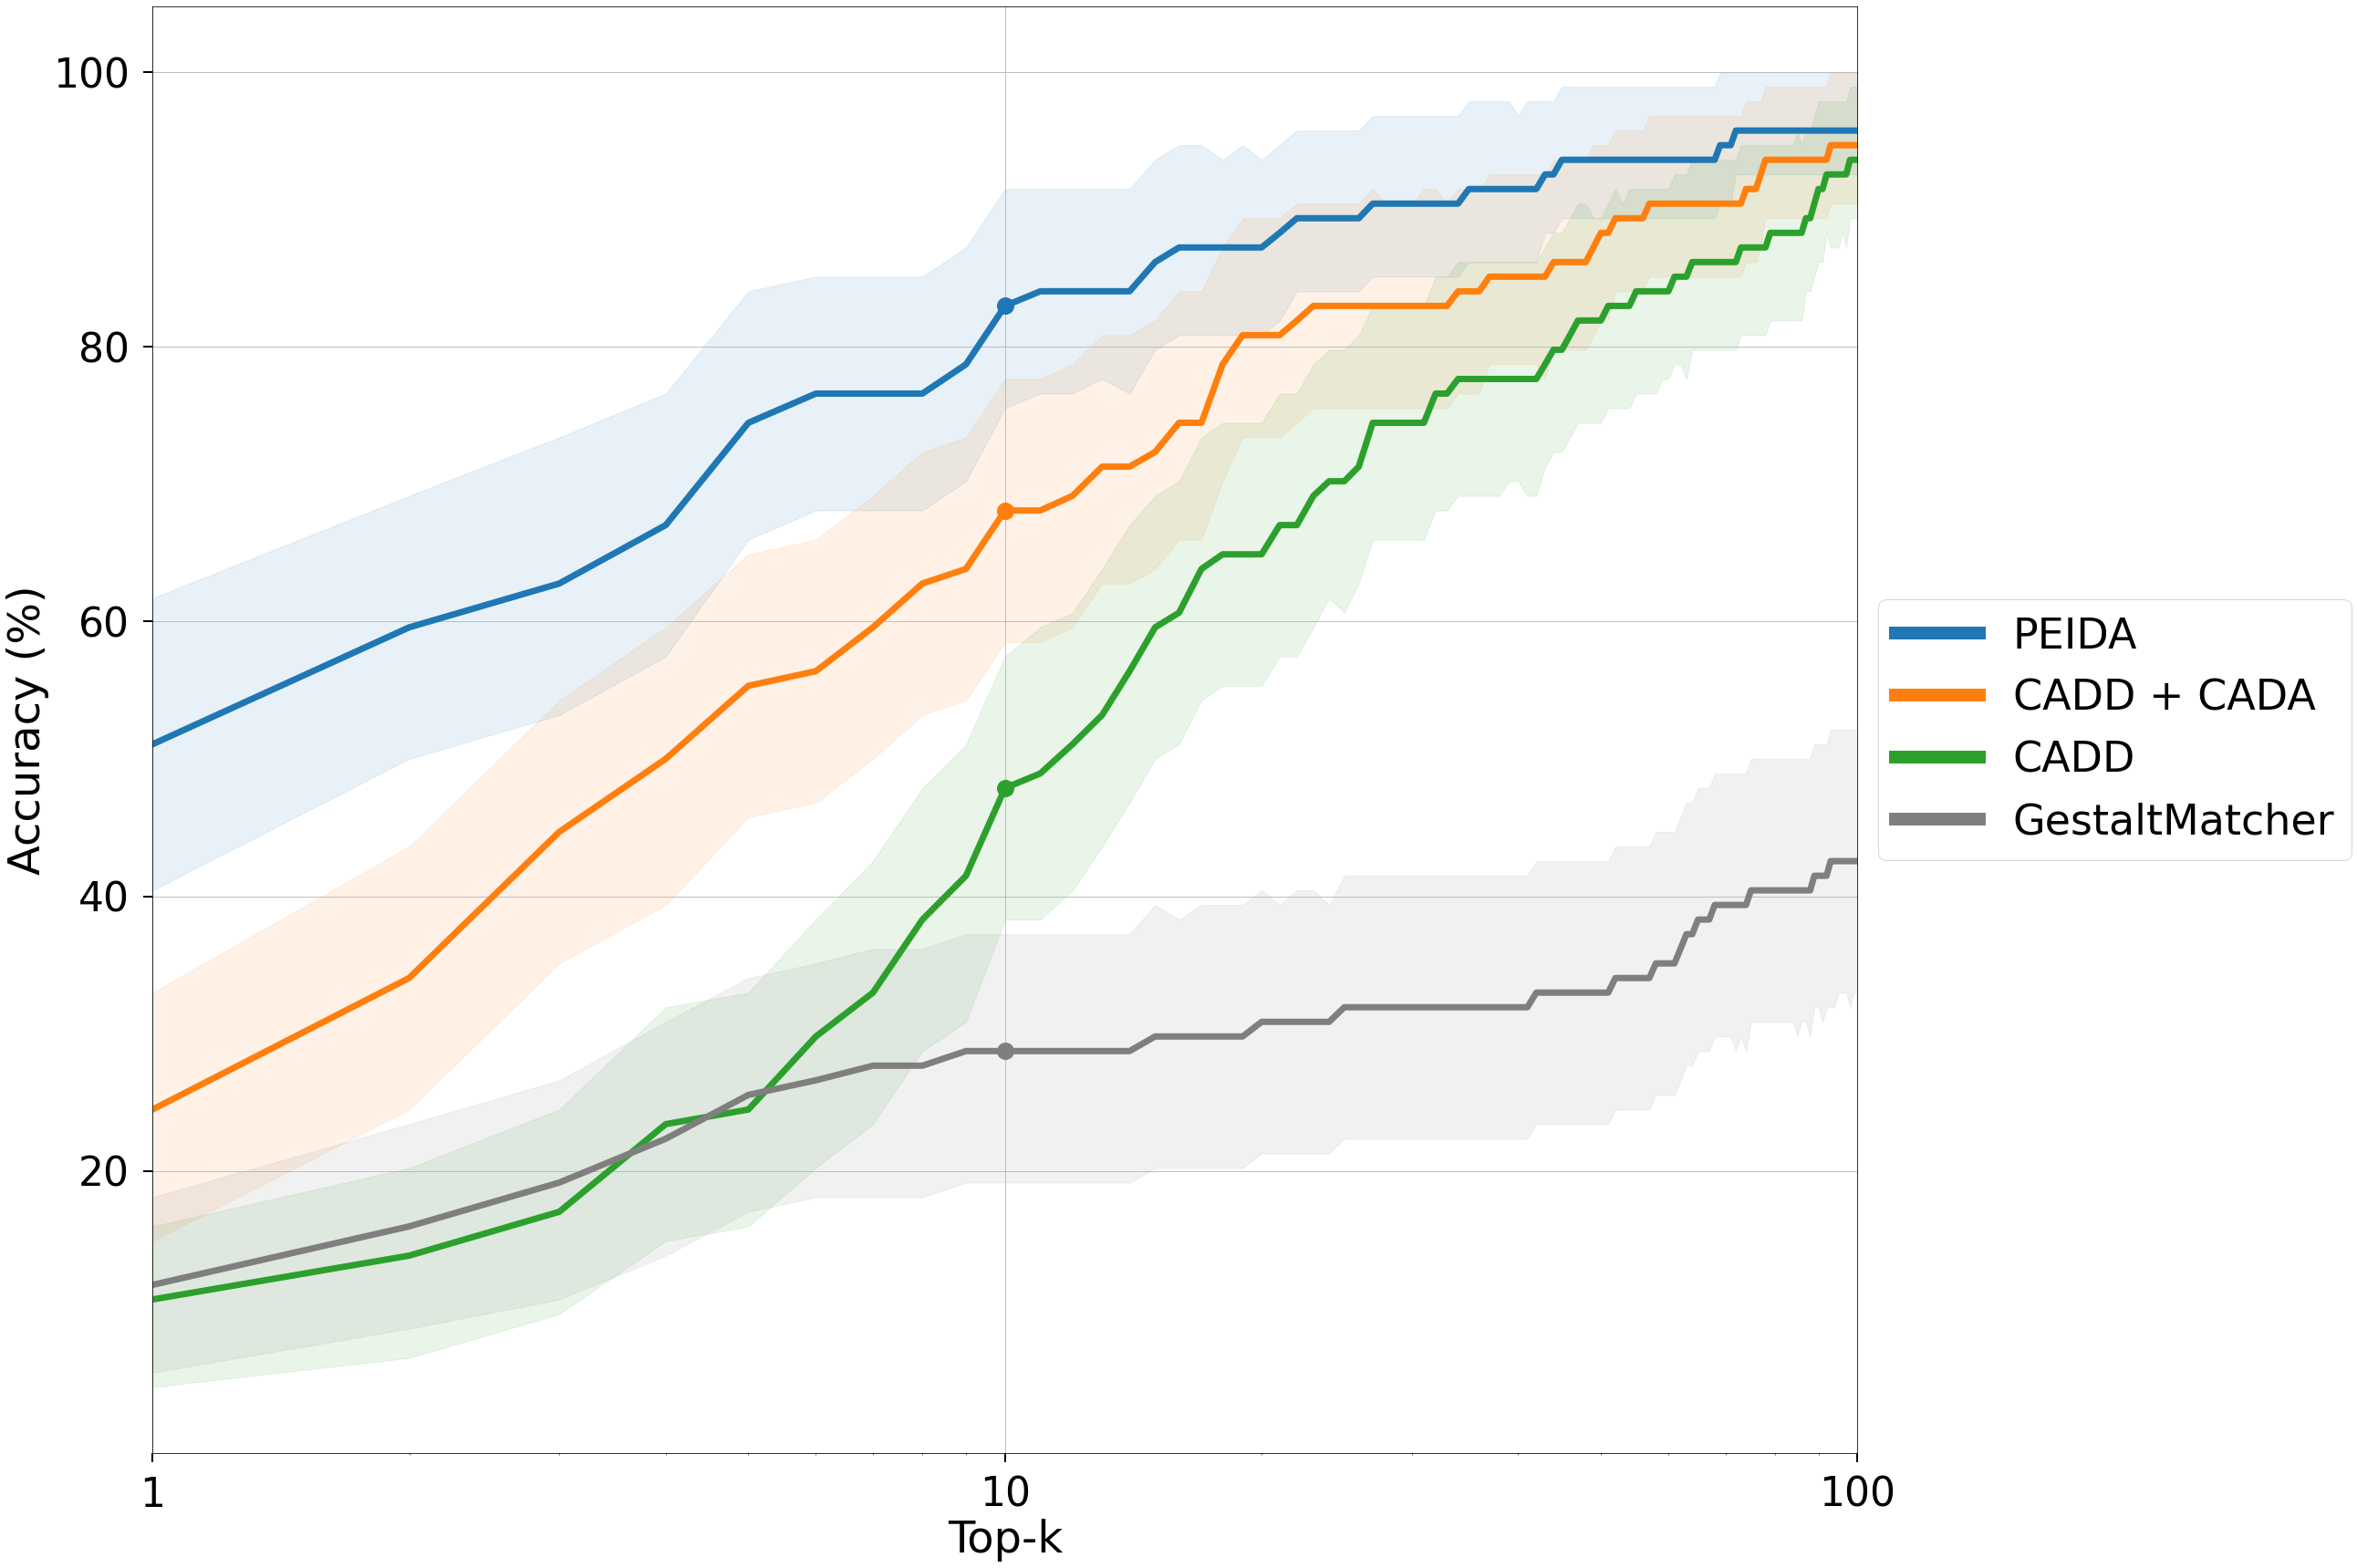

In [15]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(36, 24))

x = np.array([i for i in range(1, 101)])

markersize = 18
linewidth = 7
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:grey']
for idx, method in enumerate(['PEIDA', 'CADD + CADA', 'CADD', 'GestaltMatcher']):
    ax.plot(x, tnamse_total_means[idx], markersize=markersize, linewidth=linewidth, label=method, color=colors[idx])
    ax.plot([10], tnamse_total_means[idx][9], marker='o', markersize=markersize, color=colors[idx], linestyle = 'None')
    ax.fill_between(x, (tnamse_total_intervals[idx][:,0]), (tnamse_total_intervals[idx][:,1]), color=colors[idx], alpha=.1)
    print('----{}----'.format(method))
    print('{}: Top-1:{:.2f}; Top-10:{:.2f}'.format(method, tnamse_total_means[idx][0], tnamse_total_means[idx][9]))



tick_size = 44
label_size = 48
ax.tick_params(pad=15, length=10, width=2, labelsize=tick_size)

ax.set_xlabel('Top-k', fontsize=label_size)
ax.set_ylabel('Accuracy (%)', fontsize=label_size)

ax.set_yticks([i for i in range(20, 101, 20)], [i for i in range(20, 101, 20)])

#ax.set_title('First submission', fontsize=50)
leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 46})
ax.set_xscale("log")  
for line in leg.get_lines():
    line.set_linewidth(14.0)
    line.set_markersize(40)

fig.tight_layout()
from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.margins(x=0)
ax.set_xticks([1, 10, 100], [1, 10, 100])

ax.grid()
fig.savefig('pedia_tnamse_main_results_v7.svg')
fig.savefig('pedia_tnamse_main_results_v7.png')
plt.show()

In [16]:
#rank = pd.read_csv('classifier/pedia_v2_case_2812/rank.csv', header=None)
results_list_validation = []
for i in ['lirical', 'exomizer', 'xrare', 'amelie']:
    results = pd.read_csv('TNAMSE_pedia_results/pedia_TNAMSE_{}_filter_validation/rank.csv'.format(i), header=None)
    results_gestalt = pd.read_csv('TNAMSE_pedia_results/pedia_TNAMSE_{}_gestalt_filter_validation/rank.csv'.format(i), header=None)
    results_list_validation.append([results, results_gestalt])


In [17]:
rank_list_validation = []
for i in results_list_validation:
    ranks = get_sample_ranks(i[0])
    ranks_gestalt = get_sample_ranks(i[1])
    rank_list_validation.append([ranks, ranks_gestalt])


In [18]:
total_means_validation = []
total_intervals_validation = []
for ranks in rank_list_validation:
    mean_results, interval_results = calc_conf_interval(ranks[0])
    mean_results_g, interval_results_g = calc_conf_interval(ranks[1])
    total_means_validation.append([mean_results, mean_results_g])
    total_intervals_validation.append(np.clip([interval_results, interval_results_g], 0 ,100))

----LIRICAL----
LIRICAL   : Top-1:55.07; Top-10:85.51
LIRICAL+GM: Top-1:55.07; Top-10:94.20
change: Top-1:0.00; Top-10:8.70
----Exomiser----
Exomiser   : Top-1:53.62; Top-10:86.96
Exomiser+GM: Top-1:57.97; Top-10:95.65
change: Top-1:4.35; Top-10:8.70
----Xrare----
Xrare   : Top-1:39.13; Top-10:89.86
Xrare+GM: Top-1:55.07; Top-10:95.65
change: Top-1:15.94; Top-10:5.80
----Amelie----
Amelie   : Top-1:10.14; Top-10:62.32
Amelie+GM: Top-1:47.83; Top-10:88.41
change: Top-1:37.68; Top-10:26.09


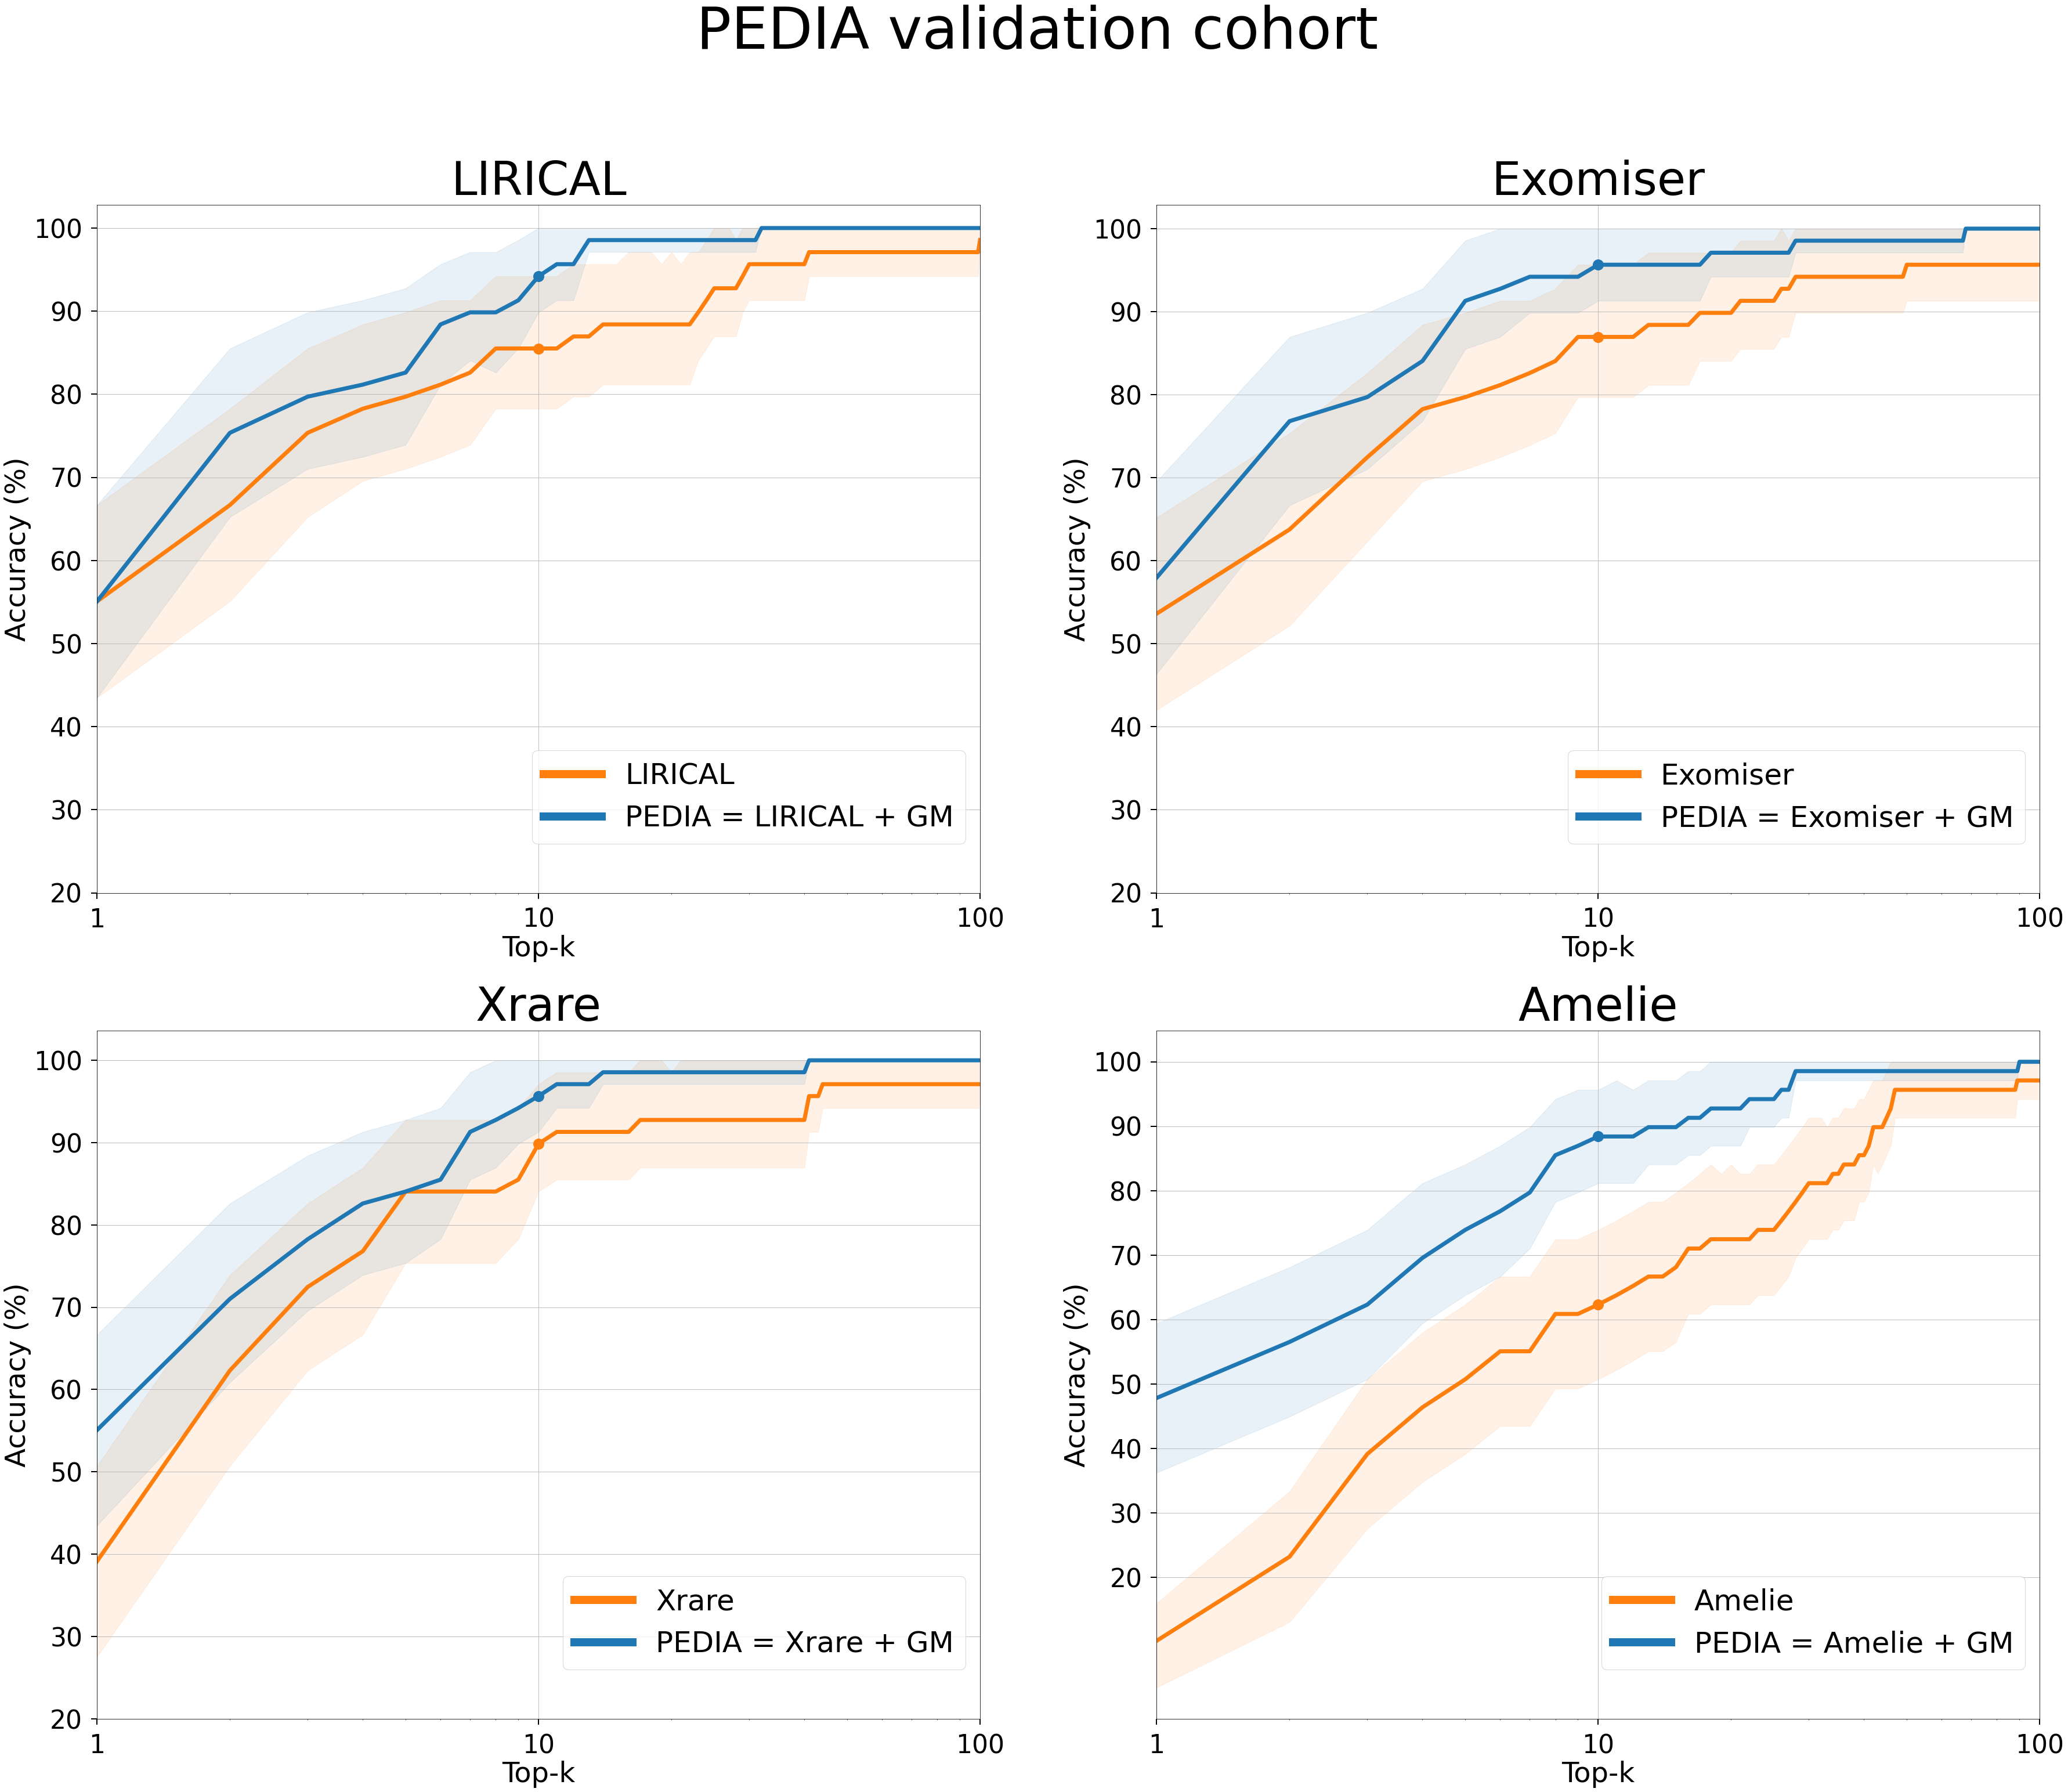

In [19]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(60, 48))

markersize = 18
linewidth = 7
tick_size = 44
label_size = 48

for idx, method in enumerate(['LIRICAL', 'Exomizer', 'Xrare', 'Amelie']):
    if method == 'Exomizer':
        method = 'Exomiser'
    #some confidence interval
    #ci = 1.96 * pedia_std_acc /np.sqrt(10)
    x = np.array([i for i in range(1, 101)])

    axs[idx//2, idx%2].plot(x, total_means_validation[idx][0], markersize=markersize, linewidth=linewidth, label=method, color='tab:orange')
    axs[idx//2, idx%2].plot([10], total_means_validation[idx][0][9], marker='o', markersize=markersize, color='tab:orange', linestyle = 'None')
    axs[idx//2, idx%2].fill_between(x, (total_intervals_validation[idx][0][:,0]), (total_intervals_validation[idx][0][:,1]), color='tab:orange', alpha=.1)

    axs[idx//2, idx%2].plot(x, total_means_validation[idx][1], linewidth=linewidth, label='PEDIA = ' + method + ' + ' + 'GM', color='tab:blue')
    axs[idx//2, idx%2].plot([10], total_means_validation[idx][1][9], marker='o', markersize=markersize, color='tab:blue', linestyle = 'None')

    axs[idx//2, idx%2].fill_between(x, (total_intervals_validation[idx][1][:,0]), (total_intervals_validation[idx][1][:,1]), color='tab:blue', alpha=.1)
    axs[idx//2, idx%2].tick_params(pad=15, length=10, width=2, labelsize=tick_size)

    axs[idx//2, idx%2].set_xlabel('Top-k', fontsize=label_size)
    axs[idx//2, idx%2].set_ylabel('Accuracy (%)', fontsize=label_size)

    axs[idx//2, idx%2].set_yticks([i for i in range(20, 101, 10)], [i for i in range(20, 101, 10)])

    leg = axs[idx//2, idx%2].legend(loc='lower right', bbox_to_anchor=(1, 0.05), prop={'size': 50})
    axs[idx//2, idx%2].set_xscale("log")  
    for line in leg.get_lines():
        line.set_linewidth(14.0)
        line.set_markersize(40)

    from matplotlib.ticker import ScalarFormatter
    for axis in [axs[idx//2, idx%2].xaxis, axs[idx//2, idx%2].yaxis]:
        axis.set_major_formatter(ScalarFormatter())
    axs[idx//2, idx%2].margins(x=0)
    axs[idx//2, idx%2].set_xticks([1, 10, 100], [1, 10, 100])
    axs[idx//2, idx%2].set_title(method, fontsize=80)
    axs[idx//2, idx%2].grid()
    print('----{}----'.format(method))
    print('{}   : Top-1:{:.2f}; Top-10:{:.2f}'.format(method, total_means_validation[idx][0][0], total_means_validation[idx][0][9]))
    print('{}+GM: Top-1:{:.2f}; Top-10:{:.2f}'.format(method, total_means_validation[idx][1][0], total_means_validation[idx][1][9]))
    print('change: Top-1:{:.2f}; Top-10:{:.2f}'.format(total_means_validation[idx][1][0]-total_means_validation[idx][0][0], total_means_validation[idx][1][9]-total_means_validation[idx][0][9]))

fig.suptitle('PEDIA validation cohort', fontsize=100)
fig.savefig('pedia_tnamse_validation_results_other_methods_revision.svg')
fig.savefig('pedia_tnamse_validation_results_other_methods_revision.png')
plt.show()

# TNAMSE Validation cohort with PEDIA

In [20]:
valid_ids = ['DX206906' if i == 'DX206906_01' else i for i in results_list_validation[0][1][0].values]
print(len(valid_ids))

69


In [21]:
#rank = pd.read_csv('classifier/pedia_v2_case_2812/rank.csv', header=None)
tnamse_results_list_validation = []
for i in ['pedia', 'cadd_cada_', 'cadd_', 'gestalt_']:
    if i == 'pedia':
        i = ''

    results = pd.read_csv('TNAMSE_pedia_results/pedia_TNAMSE_revision_{}main_filter/rank.csv'.format(i), header=None)
    results = results[results[0].isin(valid_ids)]
    tnamse_results_list_validation.append(results)

In [22]:
tnamse_rank_list_validation = []
for i in tnamse_results_list_validation:
    ranks = get_sample_ranks(i)
    tnamse_rank_list_validation.append(ranks)

tnamse_total_means_validation = []
tnamse_total_intervals_validation = []
for ranks in tnamse_rank_list_validation:
    mean_results, interval_results = calc_conf_interval(ranks)
    tnamse_total_means_validation.append(mean_results)
    tnamse_total_intervals_validation.append(np.clip(interval_results, 0 ,100))

----PEIDA----
PEIDA: Top-1:49.28; Top-10:82.61
----CADD + CADA----
CADD + CADA: Top-1:17.39; Top-10:69.57
----CADD----
CADD: Top-1:8.70; Top-10:33.33
----GestaltMatcher----
GestaltMatcher: Top-1:5.80; Top-10:18.84


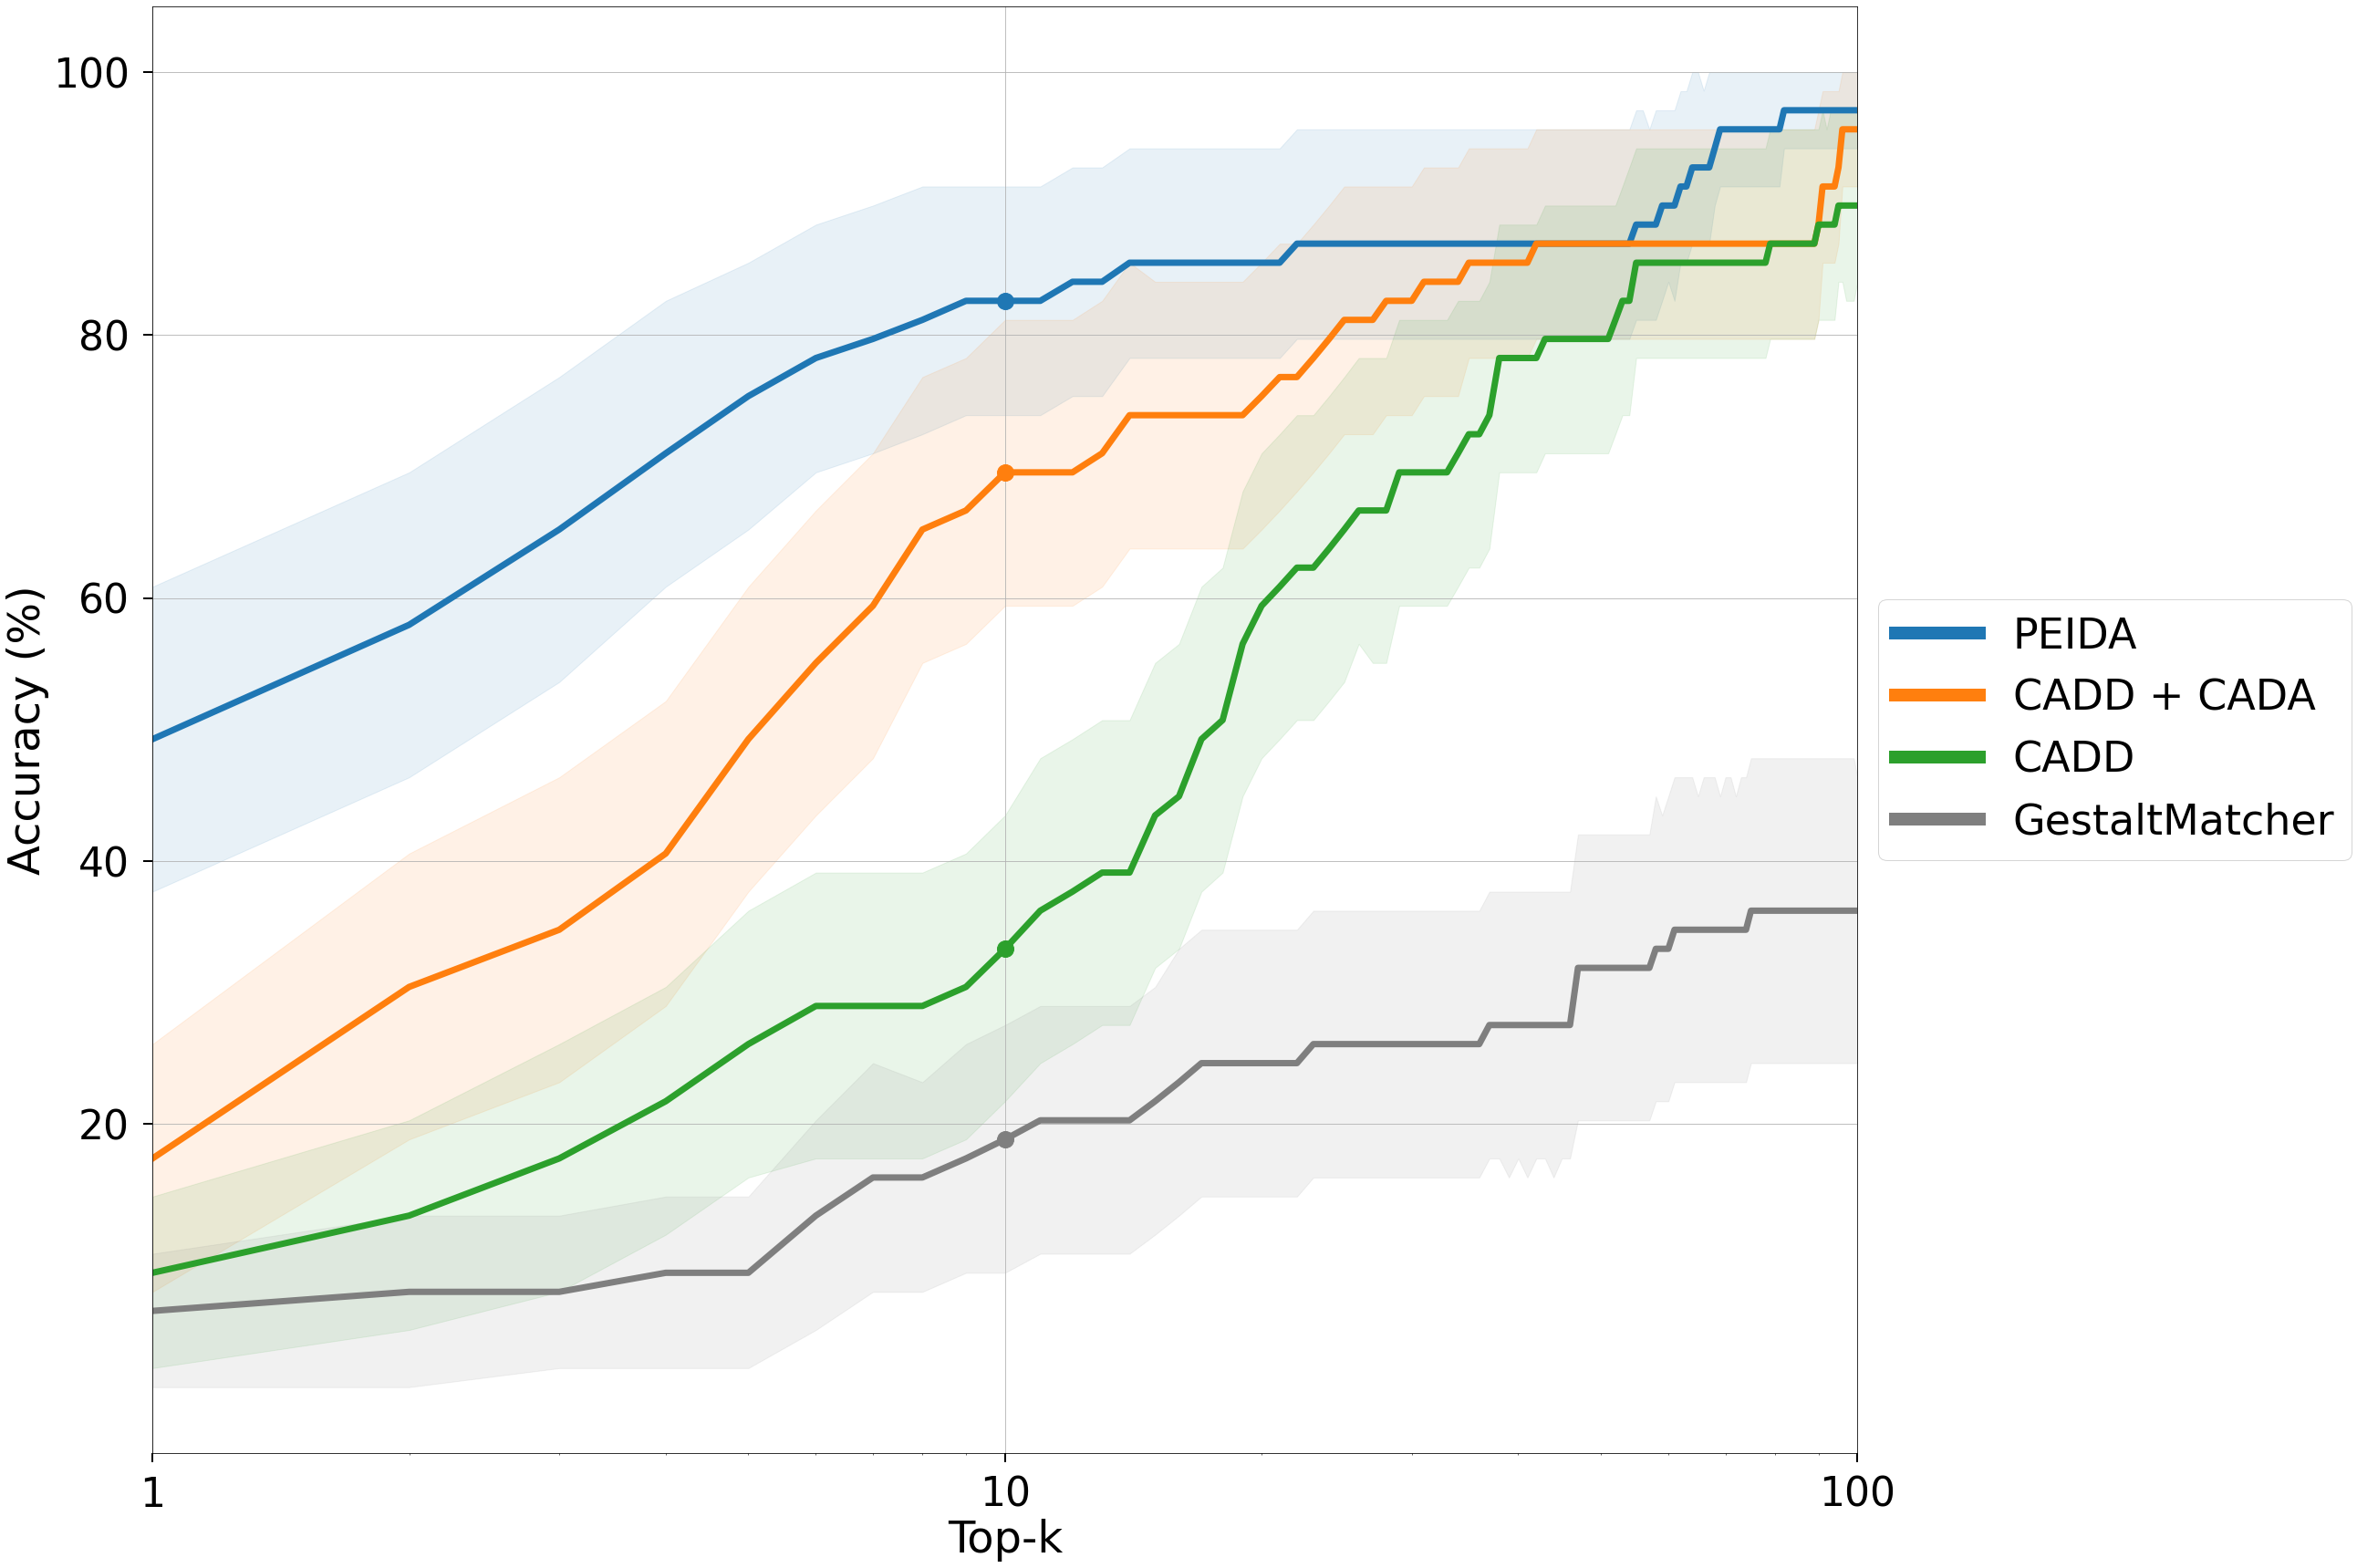

In [23]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(36, 24))

x = np.array([i for i in range(1, 101)])

markersize = 18
linewidth = 7
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:grey']
for idx, method in enumerate(['PEIDA', 'CADD + CADA', 'CADD', 'GestaltMatcher']):
    ax.plot(x, tnamse_total_means_validation[idx], markersize=markersize, linewidth=linewidth, label=method, color=colors[idx])
    ax.plot([10], tnamse_total_means_validation[idx][9], marker='o', markersize=markersize, color=colors[idx], linestyle = 'None')
    ax.fill_between(x, (tnamse_total_intervals_validation[idx][:,0]), (tnamse_total_intervals_validation[idx][:,1]), color=colors[idx], alpha=.1)
    print('----{}----'.format(method))
    print('{}: Top-1:{:.2f}; Top-10:{:.2f}'.format(method, tnamse_total_means_validation[idx][0], tnamse_total_means_validation[idx][9]))



tick_size = 44
label_size = 48
ax.tick_params(pad=15, length=10, width=2, labelsize=tick_size)

ax.set_xlabel('Top-k', fontsize=label_size)
ax.set_ylabel('Accuracy (%)', fontsize=label_size)

ax.set_yticks([i for i in range(20, 101, 20)], [i for i in range(20, 101, 20)])

#ax.set_title('First submission', fontsize=50)
leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 46})
ax.set_xscale("log")  
for line in leg.get_lines():
    line.set_linewidth(14.0)
    line.set_markersize(40)

fig.tight_layout()
from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.margins(x=0)
ax.set_xticks([1, 10, 100], [1, 10, 100])

ax.grid()
fig.savefig('pedia_tnamse_validation_results_v7.svg')
fig.savefig('pedia_tnamse_validation_results_v7.png')
plt.show()